In [1]:
#| default_exp learner

In [1]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [2]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
logging.disable(logging.WARNING)

## Learner

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [7]:
bs = 1024
tds = dsd.with_transform(transformi)

In [8]:
from torch.utils.data import DataLoader
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*[DataLoader(ds,batch_size,num_workers = 4, collate_fn = collate_dict(ds)) for ds in dd.values()])


In [9]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [10]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr) # from __init__
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [11]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [12]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.185229296875 0.5955
0 False 1.1353948660714286 0.6086857142857143


## Basic Callbacks Learner

In [13]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [14]:
#|export
class Callback(): order = 0

In [15]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [16]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [17]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')


run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

# Counts the number of time after_batch is being called , sort of a count for batches

Completed 1 batches
Completed 2 batches
Completed 3 batches
Completed 4 batches


In [18]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        if train :
            print("Training = True")
        else :
            print("Training = False")
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: 
                    print("CancelBatchException")
                    pass
            self.callback('after_epoch')
        except CancelEpochException: 
            print("CancelEpochException")
            pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: 
            print("CancelFitException")
            pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [19]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [20]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Training = True
Training = False


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Completed 69 batches


In [21]:
len(dls.train) + len(dls.valid)

69

In [22]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelEpochException()

In [23]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Training = True


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


CancelEpochException
Training = False


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

CancelEpochException
Completed 2 batches


In [24]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelBatchException()

learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)


Training = True


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchEx

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


CancelBatchException
CancelBatchException
CancelBatchException
Training = False


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException
CancelBatchException


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


CancelBatchException
CancelBatchException
Completed 69 batches


## Metrics

In [25]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [26]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [27]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [28]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

```
pip install torcheval
```

In [29]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean

In [30]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [31]:
metric.update(tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.75)

In [32]:
metric.reset()
metric.update(tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(1.)

In [33]:
mean = Mean()
mean.update(tensor([2, 1, 3]))
mean.update(tensor([4, 5, 6]))
mean.compute()

tensor(3.50, dtype=torch.float64)

In [34]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [35]:
??Mean

Init signature: Mean(*, device: Optional[torch.device] = None) -> None
Source:        
class Mean(Metric[torch.Tensor]):
    """
    Calculate the weighted mean value of all elements in all the input tensors.
    When weight is not provided, it calculates the unweighted mean.
    Its functional version is ``torcheval.functional.mean()``.

    Examples::

        >>> import torch
        >>> from torcheval.metrics import Mean
        >>> metric = Mean()
        >>> metric.update(1)
        >>> metric.update(torch.tensor([2, 3]))
        >>> metric.compute()
        tensor(2.)

        >>> metric.update(torch.tensor(-1)).compute()
        tensor(1.25)

        >>> metric.reset()
        >>> metric.update(torch.tensor(-1)).compute()
        tensor(-1.)

        >>> metric = Mean()
        >>> metric.update(torch.tensor([2, 3]), torch.tensor([0.2, 0.8])).compute()
        tensor(2.8)
        >>> metric.update(torch.tensor([4, 5]), 0.5).compute()
        tensor(3.65)
        >>> metric.upda

In [36]:
a = 3
b = "abc"
type(a).__name__ , type(b).__name__

('int', 'str')

In [37]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelBatchException()

cb = SingleBatchCB()
method = getattr(cb, 'after_batch', None)
method , cb.after_batch # Both are exactly the same . Just different ways of implementing 

(<bound method SingleBatchCB.after_batch of <__main__.SingleBatchCB object at 0x297018b50>>,
 <bound method SingleBatchCB.after_batch of <__main__.SingleBatchCB object at 0x297018b50>>)

In [38]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        """ Performs forward and backward passes on a single batch . Note that the method gets the data of the batch from self.batch """
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        """ Performs forward and backward passes on a single batch . Note that the method gets the data of the batch from self.batch """
        self.model.train(train)
        if train :
            print("Training = True")
        else :
            print("Training = False")
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: 
                    print("CancelBatchException")
                    pass
            self.callback('after_epoch')
        except CancelEpochException: 
            print("CancelEpochException")
            pass
    
    def fit(self, n_epochs):
        """ Contains the training loop operation , invokes one epoch and one batch """
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: 
            print("CancelFitException")
            pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [39]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        """ stores metrics and creates a metric called loss to be used internally """
        # import pdb ; pdb.set_trace()
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): 
        """ prints the result every single time """
        print(d)
    
    def before_fit(self, learn): 
        """ Storing object of this class as an attribute for the learner claass object (Happens only once per training loop since fit fucntion is called only once) """
        learn.metrics = self


    def before_epoch(self, learn): 
        """ resets all the metrics in our dictionary before every epoch to refresh our metrics """
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        """ Computes the values for all our metrics and stores it inside log and prints it along with epoch and train"""
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        """ Does 3 things 
        1. Empties all the tensors of the batch to CPU to clear out GPU space
        2. Metrics (initialized at the start like MulticlassAccuracy() excluding loss ) are updated based on the batch's performance 
        3. updates the loss collected after each batch's run 
        """
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [40]:
def_device

'mps'

In [41]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        """ Stores the model into device (GPU)  """
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): 
        """ Stores the batch into device (GPU) before processing each batch """
        learn.batch = to_device(learn.batch, device=self.device)

In [42]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics , CompletionCB()])
learn.fit(1)

Training = True


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


{'accuracy': '0.604', 'loss': '1.187', 'epoch': 0, 'train': 'train'}
Training = False


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


{'accuracy': '0.693', 'loss': '0.813', 'epoch': 0, 'train': 'eval'}
Completed 69 batches


## Flexible learner

In [50]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

class Learner():
    """ Changes from the previous learner :
    1. context manager for callback methods execution
    2. remove one_batch and convert that into a seperate callback
    3. self.training as property  from self.model.training
    
    """
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    
    @contextmanager
    def cb_ctx(self, nm):
        """ Setting up context manager to reduce the lines of code since before_nm and after_nm is used in the following names :
            nm = ['fit' , 'epoch' , 'batch'] """
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        """ Same as last one_epoch function with just a simple change with context manager for callbacks """
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()          # check __getattr__ (inherited from TrainCB)
                    self.get_loss()         # check __getattr__ (inherited from TrainCB)
                    if self.training: 
                        self.backward()     # check __getattr__ (inherited from TrainCB)
                        self.step()         # check __getattr__ (inherited from TrainCB)
                        self.zero_grad()    # check __getattr__ (inherited from TrainCB)
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        # import pdb;pdb.set_trace()
        if name in ('predict','get_loss','backward','step','zero_grad'): 
            return partial(self.callback, name) # (inherited from TrainCB)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training


    class TrainCB(Callback):
        """ Contains all the utils required for execution of one batch """
        def __init__(self, n_inp=1): self.n_inp = n_inp      #n_inp inclusion in the later lesson
        def predict(self, learn): learn.preds = learn.model(learn.batch[0])  
        def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, learn.batch[1])
        def backward(self, learn): learn.loss.backward()
        def step(self, learn): learn.opt.step()
        def zero_grad(self, learn): learn.opt.zero_grad()

    

In [51]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

In [52]:
#|export
class ProgressCB(Callback):
    """ 
    1. Creates progress bar for each epoch 
    2. logs 

    """
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

NB: Added validation loss plotting after the lesson.

In [53]:
model = get_model()

accuracy,loss,epoch,train
0.605,1.174,0,train
0.715,0.833,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

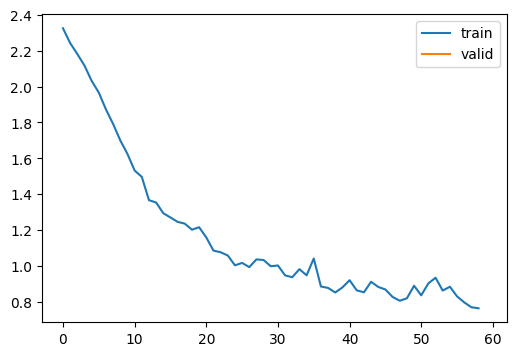

In [54]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [55]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [82]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.609,1.156,0,train
0.688,0.804,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

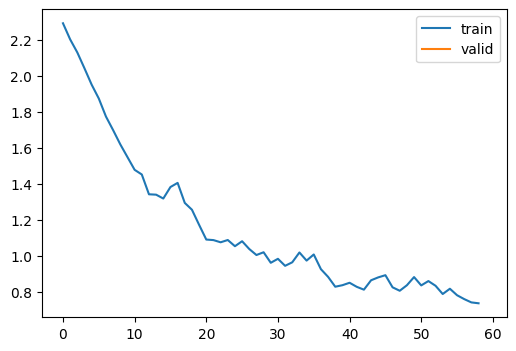

Completed 69 batches


In [123]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True),CompletionCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [85]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [86]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.668,0.945,0,train
0.793,0.586,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

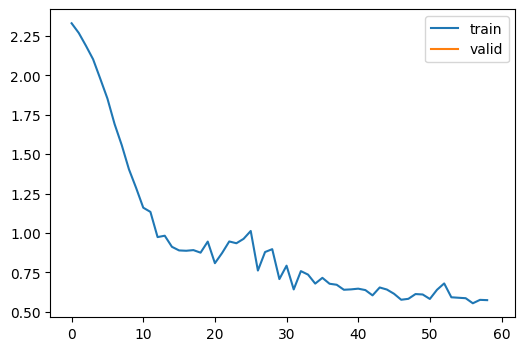

Completed 69 batches


In [87]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True),CompletionCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [116]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):

        # import pdb;pdb.set_trace()
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        print("Stats for our learning rate: ",learn.opt.param_groups[0]['lr'] , "with a loss of " , loss.item())
        if loss < self.min: self.min = loss
        if loss > self.min*3: 
            raise CancelFitException()
            # raise CancelEpochException() # with this you can make it print the completed batches
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

In [117]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

class BatchCounterCB(Callback):
    def before_fit(self, learn): self.count = 0
    def before_batch(self, learn): 
        print(f'Processing batch no : {self.count}')
    def after_batch(self, learn): 
        print(f'Processed batch no : {self.count} ')
        self.count += 1 
        
    # def after_fit(self, learn): print(f'Completed {self.count} batches')


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Processing batch no : 0
Processed batch no : 0 


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Processing batch no : 1
Processed batch no : 1 
Processing batch no : 2
Processed batch no : 2 
Processing batch no : 3
Processed batch no : 3 
Processing batch no : 4
Processed batch no : 4 
Processing batch no : 5
Processed batch no : 5 
Processing batch no : 6
Processed batch no : 6 
Processing batch no : 7
Processed batch no : 7 
Processing batch no : 8
Processed batch no : 8 
Processing batch no : 9
Processed batch no : 9 
Processing batch no : 10
Processed batch no : 10 
Processing batch no : 11
Processed batch no : 11 
Processing batch no : 12
Processed batch no : 12 
Processing batch no : 13
Processed batch no : 13 
Processing batch no : 14
Processed batch no : 14 
Processing batch no : 15
Processed batch no : 15 
Processing batch no : 16
Processed batch no : 16 
Processing batch no : 17
Processed batch no : 17 
Processing batch no : 18
Processed batch no : 18 
Processing batch no : 19
Processed batch no : 19 
Processing batch no : 20
Processed batch no : 20 
Processing batch n

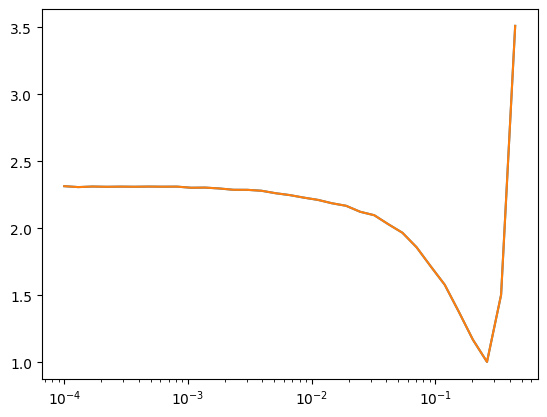

In [124]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind , CompletionCB()  ,BatchCounterCB() , ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [120]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [121]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


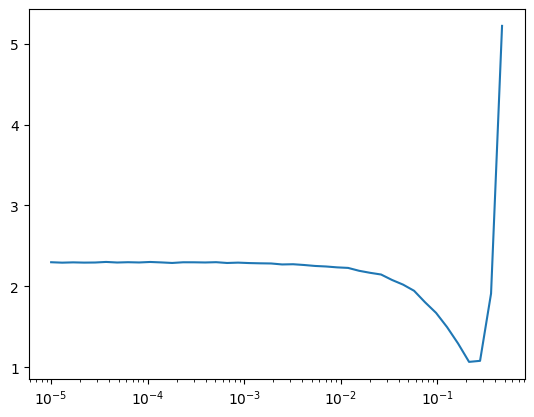

In [122]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [ ]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

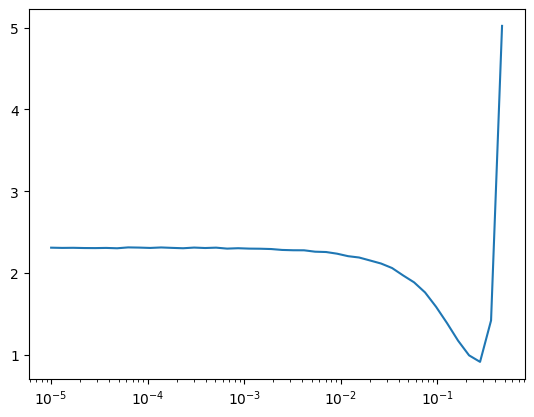

In [ ]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()

/home/tmabraham/anaconda3/envs/course22p2/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/tmabraham/course22p2/nbs/horse2zebra-latents_AB.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/home/tmabraham/anaconda3/envs/course22p2/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/tmabraham/course22p2/nbs/FIBItoHE-latents_AB.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
